In [1]:
%matplotlib inline
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import csv
import matplotlib as mpl
import csv
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['figure.dpi'] = 300

In [2]:
class reactor_sol:
  def __init__(self):   
    self.gas_mole_fracs=[]
    self.surf_fracs111=[]
    self.surf_fracs211=[]
    self.surf_fracs100=[]
    self.surf_fracs110=[]
    self.surf_fracsEdge1=[]
    self.surf_fracsEdge2=[]
    self.Ti=[]

In [3]:
def reactorCalc(n, facetName= None, sensVar= None, val= None, ind= None):

    #Some parameters
    T=383                                   # Initial temperature in K
    p=1                                     # pressure in bar
    volume = 0.1e-6                         # volume of the catalyst zone
    beta=20.0                               # temperature ramp in K/min
    m_cat=0.040                             # catalyst mass in g
    cat_area = 10.4                         # m2/g 
    facet_fraction = [0.6923, 0.0439, 0.211, 0.0528, 0.0, 0.0] # [111, 211, 100, 110, edge12, edge23]
    sccm = 50*1e-6/60                   # Flow rate m3/s
    
    # input file containing the surface reaction mechanism
#     yaml_file = 'multifacet_noCovdep.yaml' # Default
    yaml_file = 'multifacet_covdep.yaml'   # Simulation with coverage dependent thermodynamics
    
    # Flag for Edge
    edge_present = n
    print(edge_present)

    # import the gas model and set the initial conditions
    gas = ct.Solution(yaml_file, 'gas')
    gas.TPX = T, p*ct.one_atm, 'Ar:1, CO2:0.0, CO:0'

    # import the (111) surface
    surf111 = ct.Interface(yaml_file,'surface1', [gas])
    surf111.TP = T, p*ct.one_atm
    surf111.coverages = {'site(111)':1, 'O(111)':0, 'OC(111)':0 , 'CO2(111)':0}
    
    # import the (211) surface
    surf211 = ct.Interface(yaml_file,'surface2', [gas])
    surf211.TP = T, p*ct.one_atm
    surf211.coverages = {'site(211)':1, 'O(211)':0, 'OC(211)':0 , 'CO2(211)':0}

    #import the (100) surface
    surf100 = ct.Interface(yaml_file,'surface3', [gas])
    surf100.TP = T, p*ct.one_atm
    surf100.coverages = {'site(100)':1, 'O(100)':0, 'OC(100)':0 , 'CO2(100)':0}
    
    #import the (110) surface
    surf110 = ct.Interface(yaml_file,'surface4', [gas])
    surf110.TP = T, p*ct.one_atm
    surf110.coverages = {'site(110)':1, 'O(110)':0, 'OC(110)':0 , 'CO2(110)':0}
    
    saveFileName = "noEdge_"
    # Import Edge
    if(edge_present):
            edge1 = ct.Interface(yaml_file,'edge12', [gas, surf111, surf211])
            edge1.TP = T, p*ct.one_atm
            edge2 = ct.Interface(yaml_file,'edge23', [gas, surf100, surf211])
            edge2.TP = T, p*ct.one_atm
            facet_fraction = [0.6923, 0.0439, 0.211, 0.0528, 0.0439, 0.0439] # [111, 211, 100, 110, edge12, edge23]
            # Normalize
            facet_fraction = facet_fraction/np.sum(facet_fraction)
            saveFileName = "edge_"
    
    # Sensitivity analysis
    if(facetName):
        match facetName:
            case "surf100":
                 facet = surf100
            case "surf111":
                 facet = surf111
            case "surf110":
                 facet = surf110
            case "surf211":
                facet = surf211
            case "edge12":
                facet = edge1
            case "edge23":
                facet = edge2
            case _:
                Print("Error: Invalid surface")
                
    if(sensVar == "rate"):       
        if(ind < facet.n_reactions):
            # reset all multipliers
            facet.set_multiplier(1.0)
            #perturb each reaction by dk
            print("ind = ", ind, val)
            facet.set_multiplier(val, ind)
            print(facet.reaction_equations()[ind])    
            
    if(sensVar == "thermoChemistry"):
        #get the species 
        s=facet.species(ind)
        print(s)
        #call the original coefficients of the NASA polynomial
        original_coeffs = s.thermo.coeffs
        #create an empty array for the perturbation
        perturbed_coeffs = np.ones_like(original_coeffs)
        #fill the array initially with the original coeffs
        perturbed_coeffs[:] = original_coeffs
        #perturb the enthalpy of the adsorbate for the low and high temperature polynomial
        perturbed_coeffs[6] = original_coeffs[6] - val
        #This is not a mistake, both values have to be perturbed by exactly the same value, otherwise discontinuity
        perturbed_coeffs[13] = original_coeffs[13] - val
         
        #fit a new NASA polynomial through the data and update the thermo database
        s.thermo = ct.NasaPoly2(100.000, 5000.000, ct.one_atm, perturbed_coeffs)
        facet.modify_species(ind, s)    
                
    sol = reactor_sol()
    
    # Get indices of the gas and surface species,assuming (111) and (100) have the same order of species
    sol.i_co2=gas.species_index('CO2')
    sol.i_o2=gas.species_index('O2')
    sol.i_co=gas.species_index('CO')
    sol.i_surf_Ni=surf111.species_index('site(111)')
    sol.i_surf_CO=surf111.species_index('OC(111)')
    sol.i_surf_O=surf111.species_index('O(111)')
    sol.i_surf_C=surf111.species_index('C(111)')
    sol.i_surf_CO2=surf111.species_index('CO2(111)')    
    
    # Cantera setup
    upstream = ct.Reservoir(gas, name='upstream')
    downstream = ct.Reservoir(gas, name='downstream')
    
    r=ct.IdealGasReactor(gas, energy='off')
    r.volume=volume
    rsurf111=ct.ReactorSurface(surf111, r, A=facet_fraction[0]*cat_area*m_cat)
    rsurf211=ct.ReactorSurface(surf211, r, A=facet_fraction[1]*cat_area*m_cat)
    rsurf100=ct.ReactorSurface(surf100, r, A=facet_fraction[2]*cat_area*m_cat)
    rsurf110=ct.ReactorSurface(surf110, r, A=facet_fraction[3]*cat_area*m_cat)
    
    if(edge_present):
        rsurfEdge1 = ct.ReactorSurface(edge1, r, A=facet_fraction[4]*cat_area*m_cat)
        rsurfEdge2 = ct.ReactorSurface(edge2, r, A=facet_fraction[5]*cat_area*m_cat)
        
    # This is important since it adjusts the flow rates, 303 K is the temperature of the gas cylinders
    vdot = sccm  * ((ct.one_atm / gas.P) * ( 303 / 273.15)) # m^3/s 
    mass_flow_rate =  vdot* gas.density
    mflow = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
    v = ct.PressureController(r, downstream, master=mflow, K=1e-9)
    
    sim=ct.ReactorNet([r])

    ##set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-08
    sim.atol = 1.0e-14
    sim.max_err_test_fails = 10000
    rxn_time=np.linspace(0,7100,7100)
    
    sol.gas_mole_fracs=np.zeros([gas.n_species, len(rxn_time)])
    sol.surf_fracs111=np.zeros([surf111.n_species, len(rxn_time)])
    sol.surf_fracs211=np.zeros([surf211.n_species, len(rxn_time)])
    sol.surf_fracs100=np.zeros([surf100.n_species, len(rxn_time)])
    sol.surf_fracs110=np.zeros([surf110.n_species, len(rxn_time)])
    if(edge_present):
        sol.surf_fracsEdge1=np.zeros([edge1.n_species, len(rxn_time)])
        sol.surf_fracsEdge2=np.zeros([edge2.n_species, len(rxn_time)])

    sol.Ti=np.zeros(len(rxn_time))
    sim.max_time_step = 1e-4
    
    #Run the simulation
    for i in range(len(rxn_time)):
        time=rxn_time[i]
        if time < 10:
            sim.max_time_step = 2
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:1, He:0, CO2:0'
            upstream.syncState()
        elif (time > 10) and (time < 3610):   
            sim.max_time_step = 1e-3
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:0, He:0.9013, CO2:0.0987'
            upstream.syncState()
        elif (time > 3610) and (time < 3970): 
            sim.max_time_step = 10
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:1, He:0, CO2:0'
            upstream.syncState()
        elif (time > 3970) and (time < 5410):
            sim.max_time_step = 10
            upstream.thermo.TPX=323,p*ct.one_atm, 'Ar:1, He:0, CO2:0'   
            upstream.syncState()
            r.thermo.TP=323,ct.one_atm
            r.syncState()
        else:
            sim.max_time_step = 1e-2  
            r.thermo.TP=323+beta/60.0*(rxn_time[i]-5410),ct.one_atm
            r.syncState()
        
        sim.reinitialize
        sim.advance(time)
        sol.Ti[i]=r.thermo.T
        sol.gas_mole_fracs[:,i]=gas.X
        sol.surf_fracs111[:,i]=surf111.X 
        sol.surf_fracs211[:,i]=surf211.X 
        sol.surf_fracs100[:,i]=surf100.X 
        sol.surf_fracs110[:,i]=surf110.X
        if(edge_present):
            sol.surf_fracsEdge1[:,i]=edge1.X
            sol.surf_fracsEdge2[:,i]=edge2.X
            
    # Get the maximum and the position of the maximum of the TPD profile
    ind=5410

    sol.max_height_CO2=np.max(sol.gas_mole_fracs[sol.i_co2, ind:])*1e6
    sol.max_Temp_CO2=sol.Ti[np.argmax(sol.gas_mole_fracs[sol.i_co2,ind:])+ind]

    sol.max_height_CO=np.max(sol.gas_mole_fracs[sol.i_co, ind:])*1e6
    sol.max_Temp_CO=sol.Ti[np.argmax(sol.gas_mole_fracs[sol.i_co,ind:])+ind]
        
    print(sol.max_height_CO2)
    
    return sol

In [4]:
# Plot gas-phase species
def plot_gasSpecies(sol0, sol1):
    plt.rcParams['figure.figsize']=(12,6)
    plt.rcParams['axes.linewidth'] = 1.5
    gs = gridspec.GridSpec(1, 1)
    plt.rcParams.update({'font.size': 18})
    #gs.update(wspace = 0.4)
    ax0 = plt.subplot(gs[0])
    idx = 5410
    ax0.plot(sol0.Ti[idx:], 1e6*sol0.gas_mole_fracs[sol0.i_co,idx:], label='CO$^0$',color='k', linestyle='dashed', linewidth=3)
    ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co,idx:], label='CO$^{Diff}$',color='k', linewidth=3)
    ax0.plot(sol0.Ti[idx:], 1e6*sol0.gas_mole_fracs[sol0.i_co2,idx:], label='CO$_2^0$',color='b', linestyle='dashed', linewidth=3)
    ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co2,idx:], label='CO$_2^{Diff}$',color='b', linewidth=3)
    ax0.set_xlabel('Temperature [K]')
    ax0.set_xlim([323, 900])
    #ax0.set_ylim([0, 1000])
    ax0.set_ylabel('Species concentration [ppm]')
    ax0.legend()
    plt.savefig('gasPhase.png', dpi=300)
    plt.savefig('gasPhase.svg', dpi=1000)
    #plt.savefig('gasPhase.pdf', dpi=1000)
    plt.show()

In [5]:
# Plot surface species

def plot_surfSpecies(sol0, sol1, arr1, arr2, filename):
    plt.rcParams['figure.figsize']=(12,6)
    plt.rcParams['axes.linewidth'] = 1.5
    gs = gridspec.GridSpec(1, 1)
    plt.rcParams.update({'font.size': 18})
    #gs.update(wspace = 0.4)
    i_surf_CO = sol0.i_surf_CO
    i_surf_O = sol0.i_surf_O
    i_surf_CO2 = sol0.i_surf_CO2
    i_surf_Ni = sol0.i_surf_Ni
    ax0 = plt.subplot(gs[0])
    idx = 5410
    ax0.plot(sol0.Ti[idx:], arr1[sol0.i_surf_CO,idx:], label='$\mathrm{CO(s)}^0$', linestyle='dashed', color='k', linewidth=3)
    ax0.plot(sol0.Ti[idx:], arr1[sol0.i_surf_O,idx:], label='$\mathrm{O(s)}^0$', linestyle='dashed', color='b', linewidth=3)
    #ax0.plot(sol0.Ti[idx:], arr1[sol0.i_surf_CO2,idx:], label='$\mathrm{CO2(s)}^0$', linestyle='dashed', color='r', linewidth=3)
    ax0.plot(sol0.Ti[idx:], arr1[sol0.i_surf_Ni,idx:], label='$\mathrm{Ni(s)}^0$', linestyle='dashed', color='m', linewidth=3)#ax0.plot(sol1.Ti[100:], sol0.surf_fracs111[i_surf_CO,100:], label='$\mathrm{CO(111)}$', color='k', linewidth=3)
    ax0.plot(sol1.Ti[idx:], arr2[sol1.i_surf_CO,idx:], label='$\mathrm{CO(s)}^{Diff}$', color='k', linewidth=3)
    ax0.plot(sol1.Ti[idx:], arr2[sol1.i_surf_O,idx:], label='$\mathrm{O(s)}^{Diff}$', color='b', linewidth=3)
    #ax0.plot(sol1.Ti[idx:], arr2[sol1.i_surf_CO2,idx:], label='$\mathrm{CO2(s)}^{Diff}$', color='r', linewidth=3)
    ax0.plot(sol1.Ti[idx:], arr2[sol1.i_surf_Ni,idx:], label='$\mathrm{Ni(s)}^{Diff}$', color='m', linewidth=3)
    ax0.set_xlabel('Temperature [K]')
    ax0.set_xlim([323, 900])
    #ax0.set_ylim([0, 1200])
    ax0.set_ylabel('Species coverages []')
    ax0.legend()#(bbox_to_anchor=(0, 0.85, 1.4, 0), ncol = 1, loc='upper right')
    #plt.title('A_edge = '+str(area))
    plt.savefig(filename + ".png", dpi=300)
    plt.savefig(filename + ".svg", dpi=1000)
    #plt.savefig(filename + ".pdf", dpi=1000)
    plt.show()

In [6]:
import csv
def write2CSV(filename, surfname, data, fields = None):
    
    with open(filename, 'a', newline='') as csvfile:
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)
        
        # writing the data 
        csvwriter.writerow("\n")
        csvwriter.writerow(surfname)
        csvwriter.writerow(fields)
        csvwriter.writerows(data)
        csvwriter.writerow("\n")

In [7]:
# # Edge
sol1 = reactorCalc(1)
print(sol1.max_height_CO2, sol1.max_height_CO, sol1.max_Temp_CO2, sol1.max_Temp_CO)

# # No edge
sol0 = reactorCalc(0)
print(sol0.max_height_CO2, sol0.max_height_CO, sol0.max_Temp_CO2, sol0.max_Temp_CO)

1
229.77161420593598
229.77161420593598 21.34777812086724 430.26909893412204 655.967554115603
0
281.6773987463734
281.6773987463734 42.895916723931236 428.9355777809081 663.6353007465841


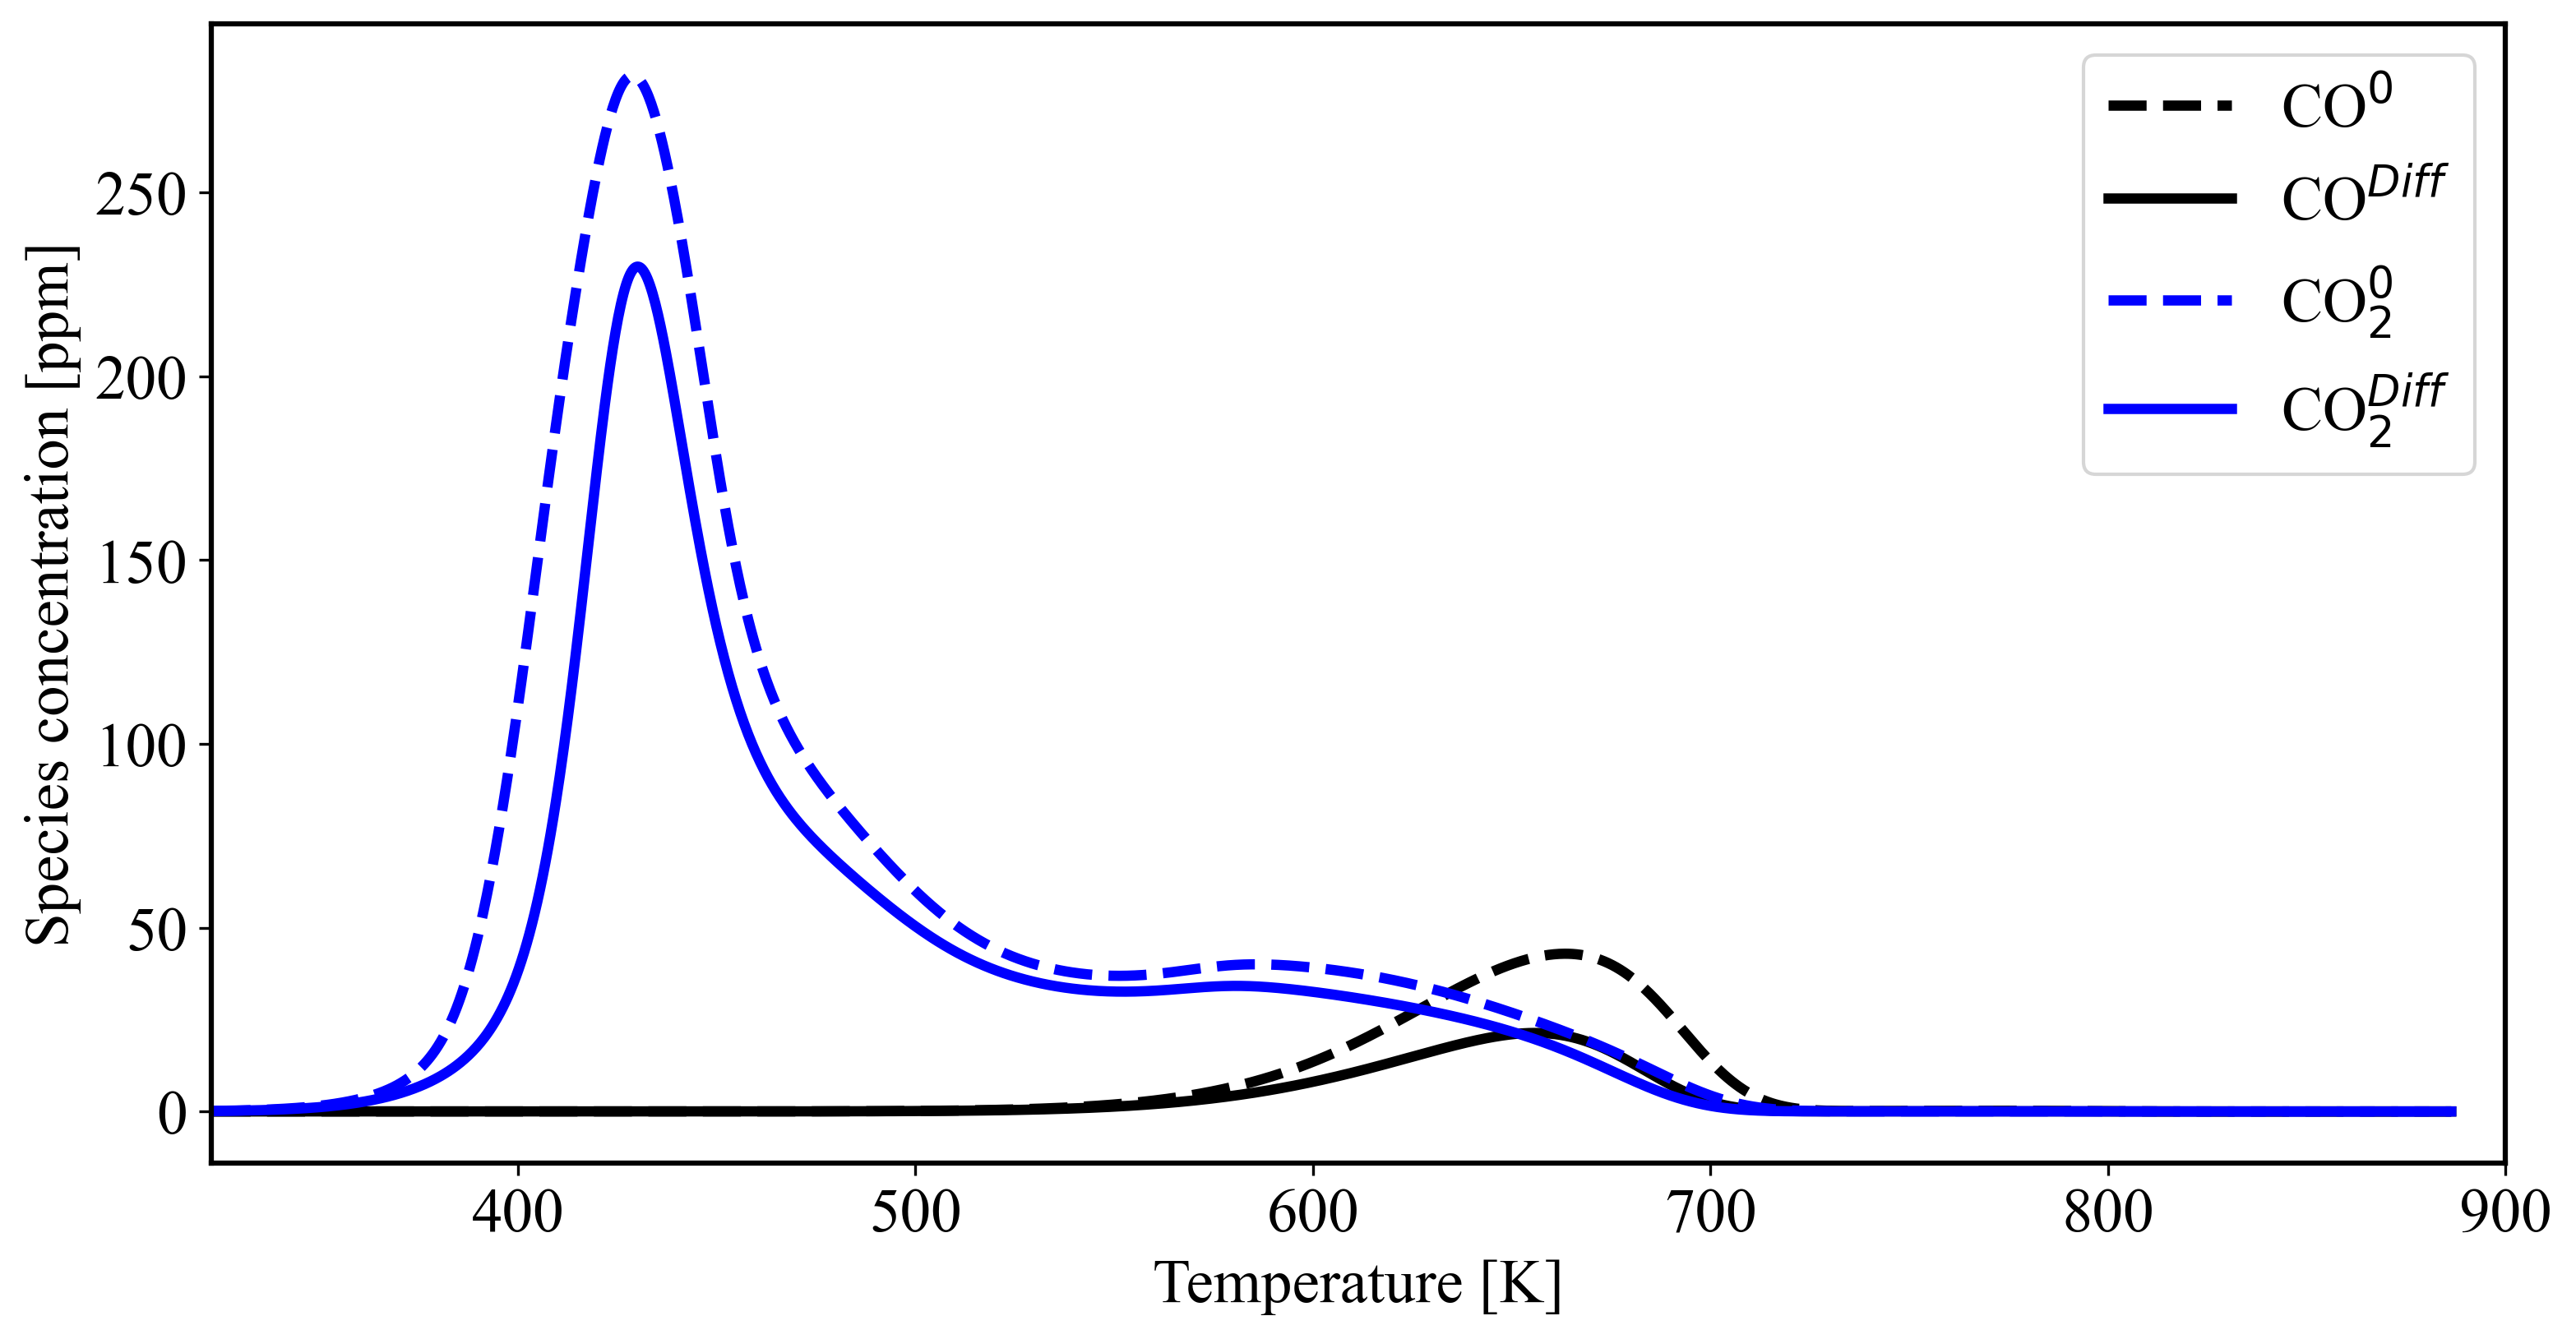

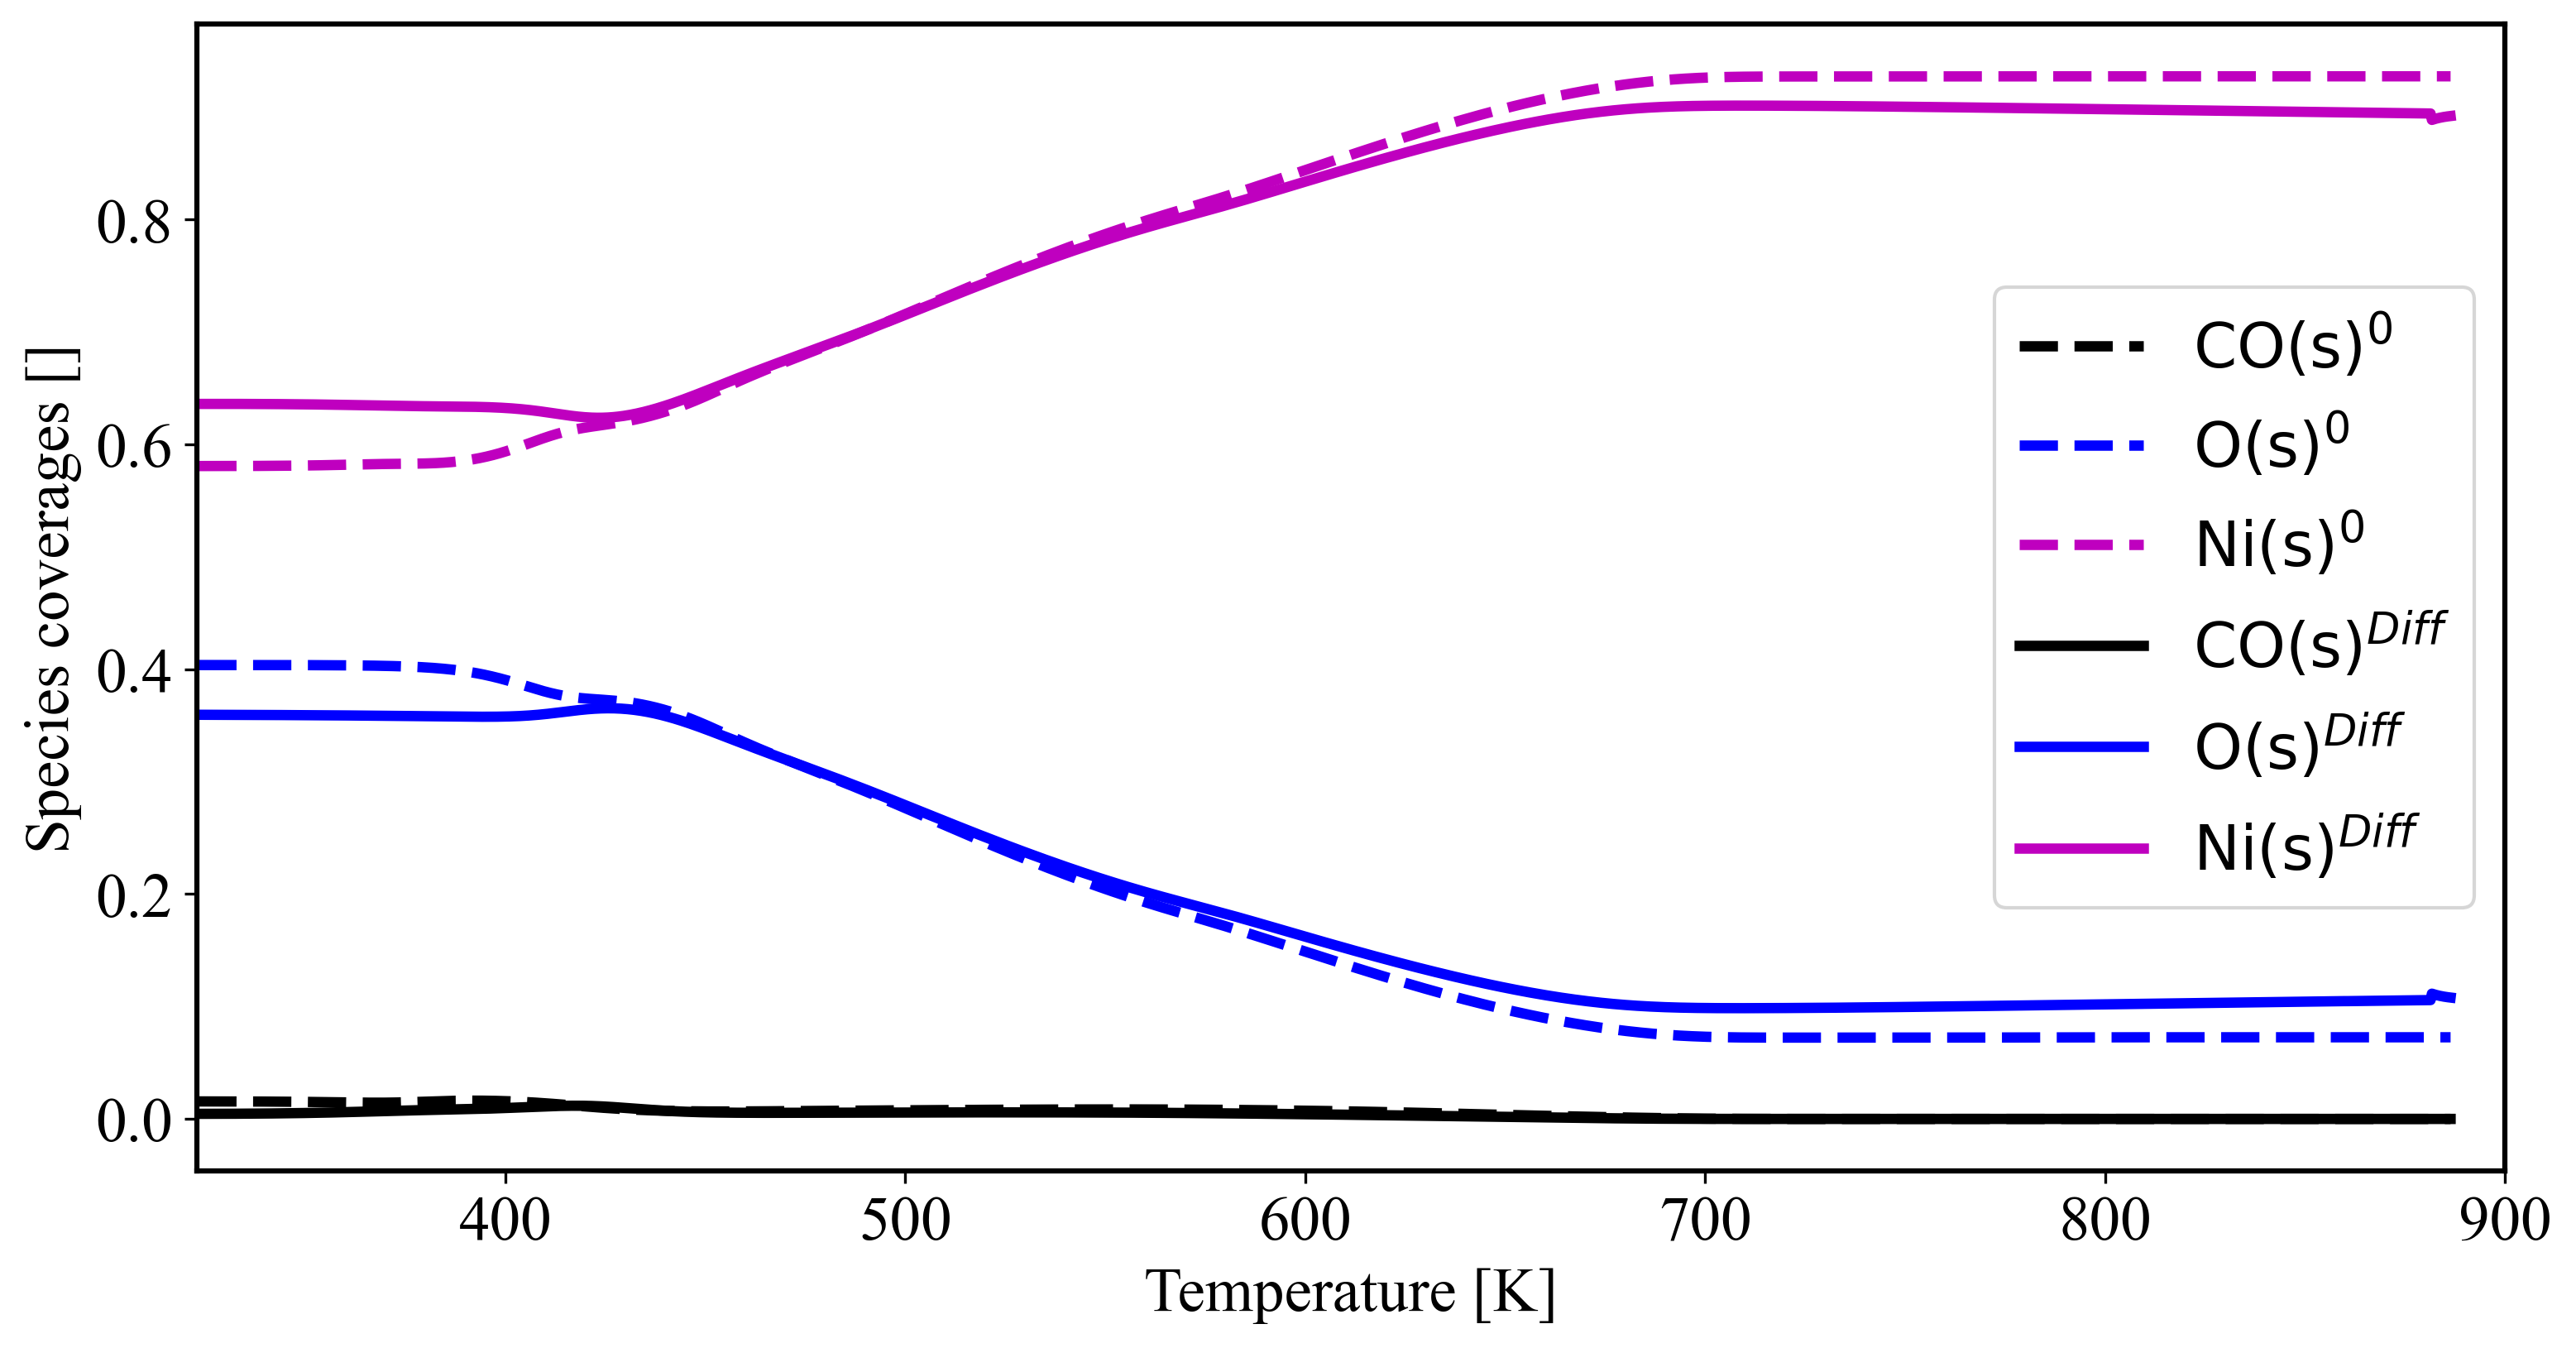

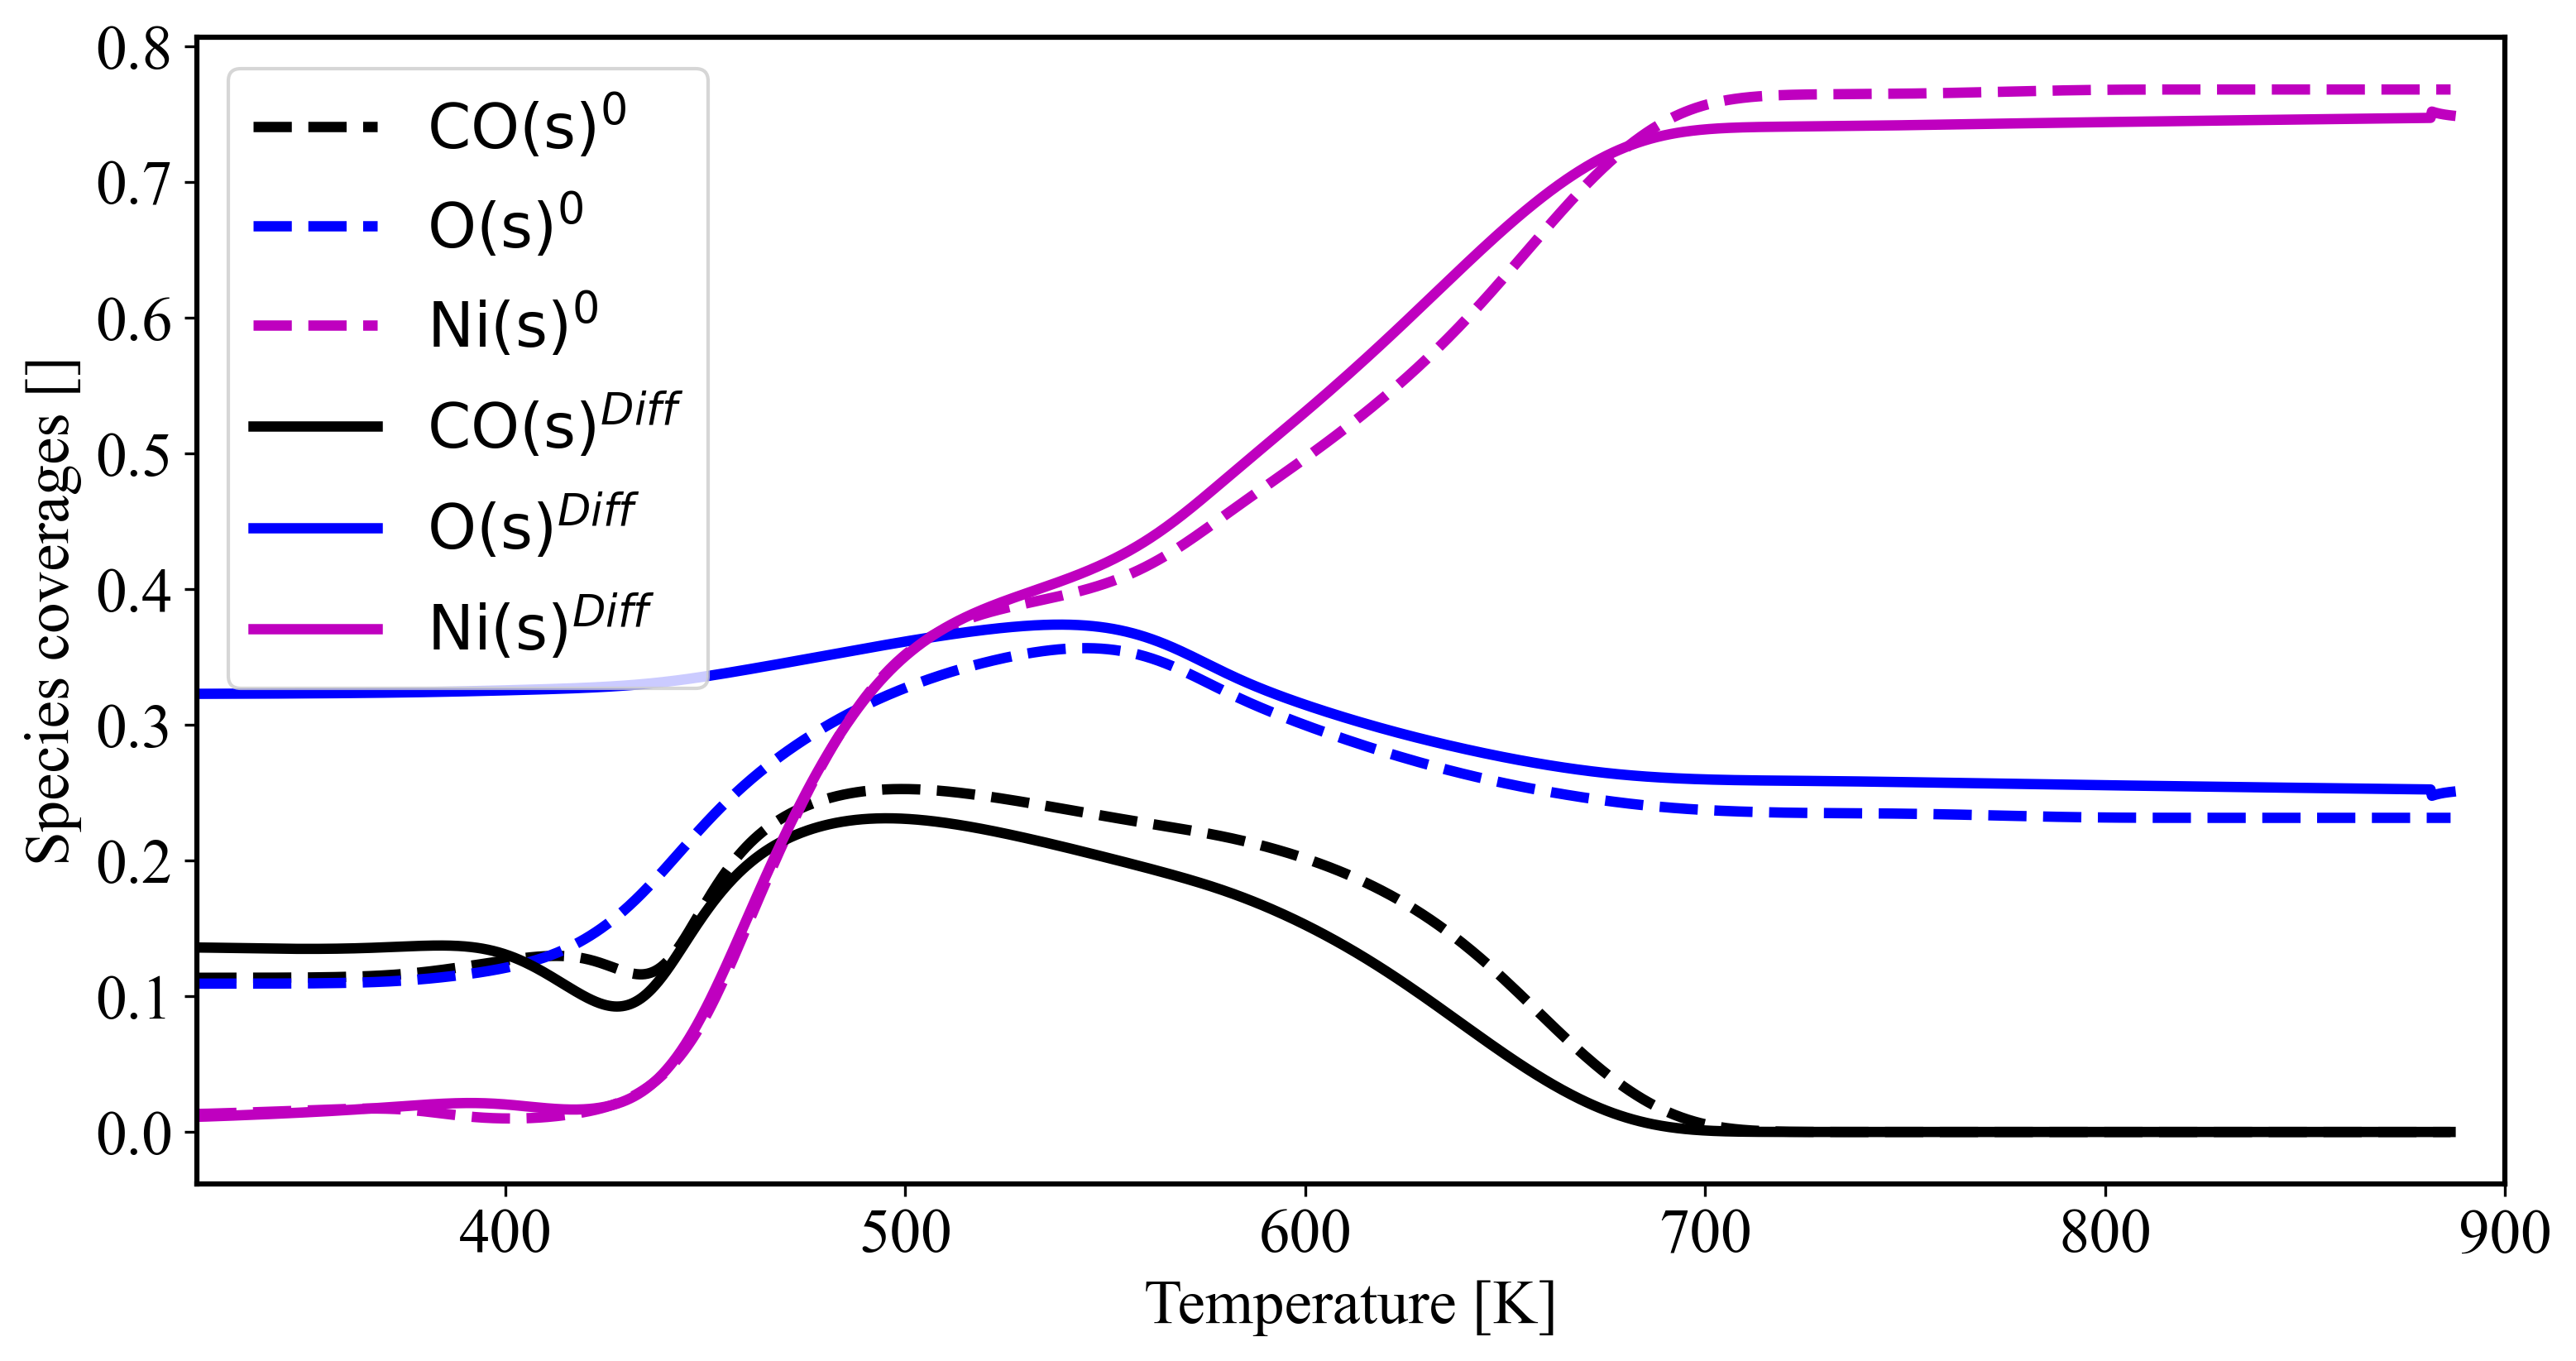

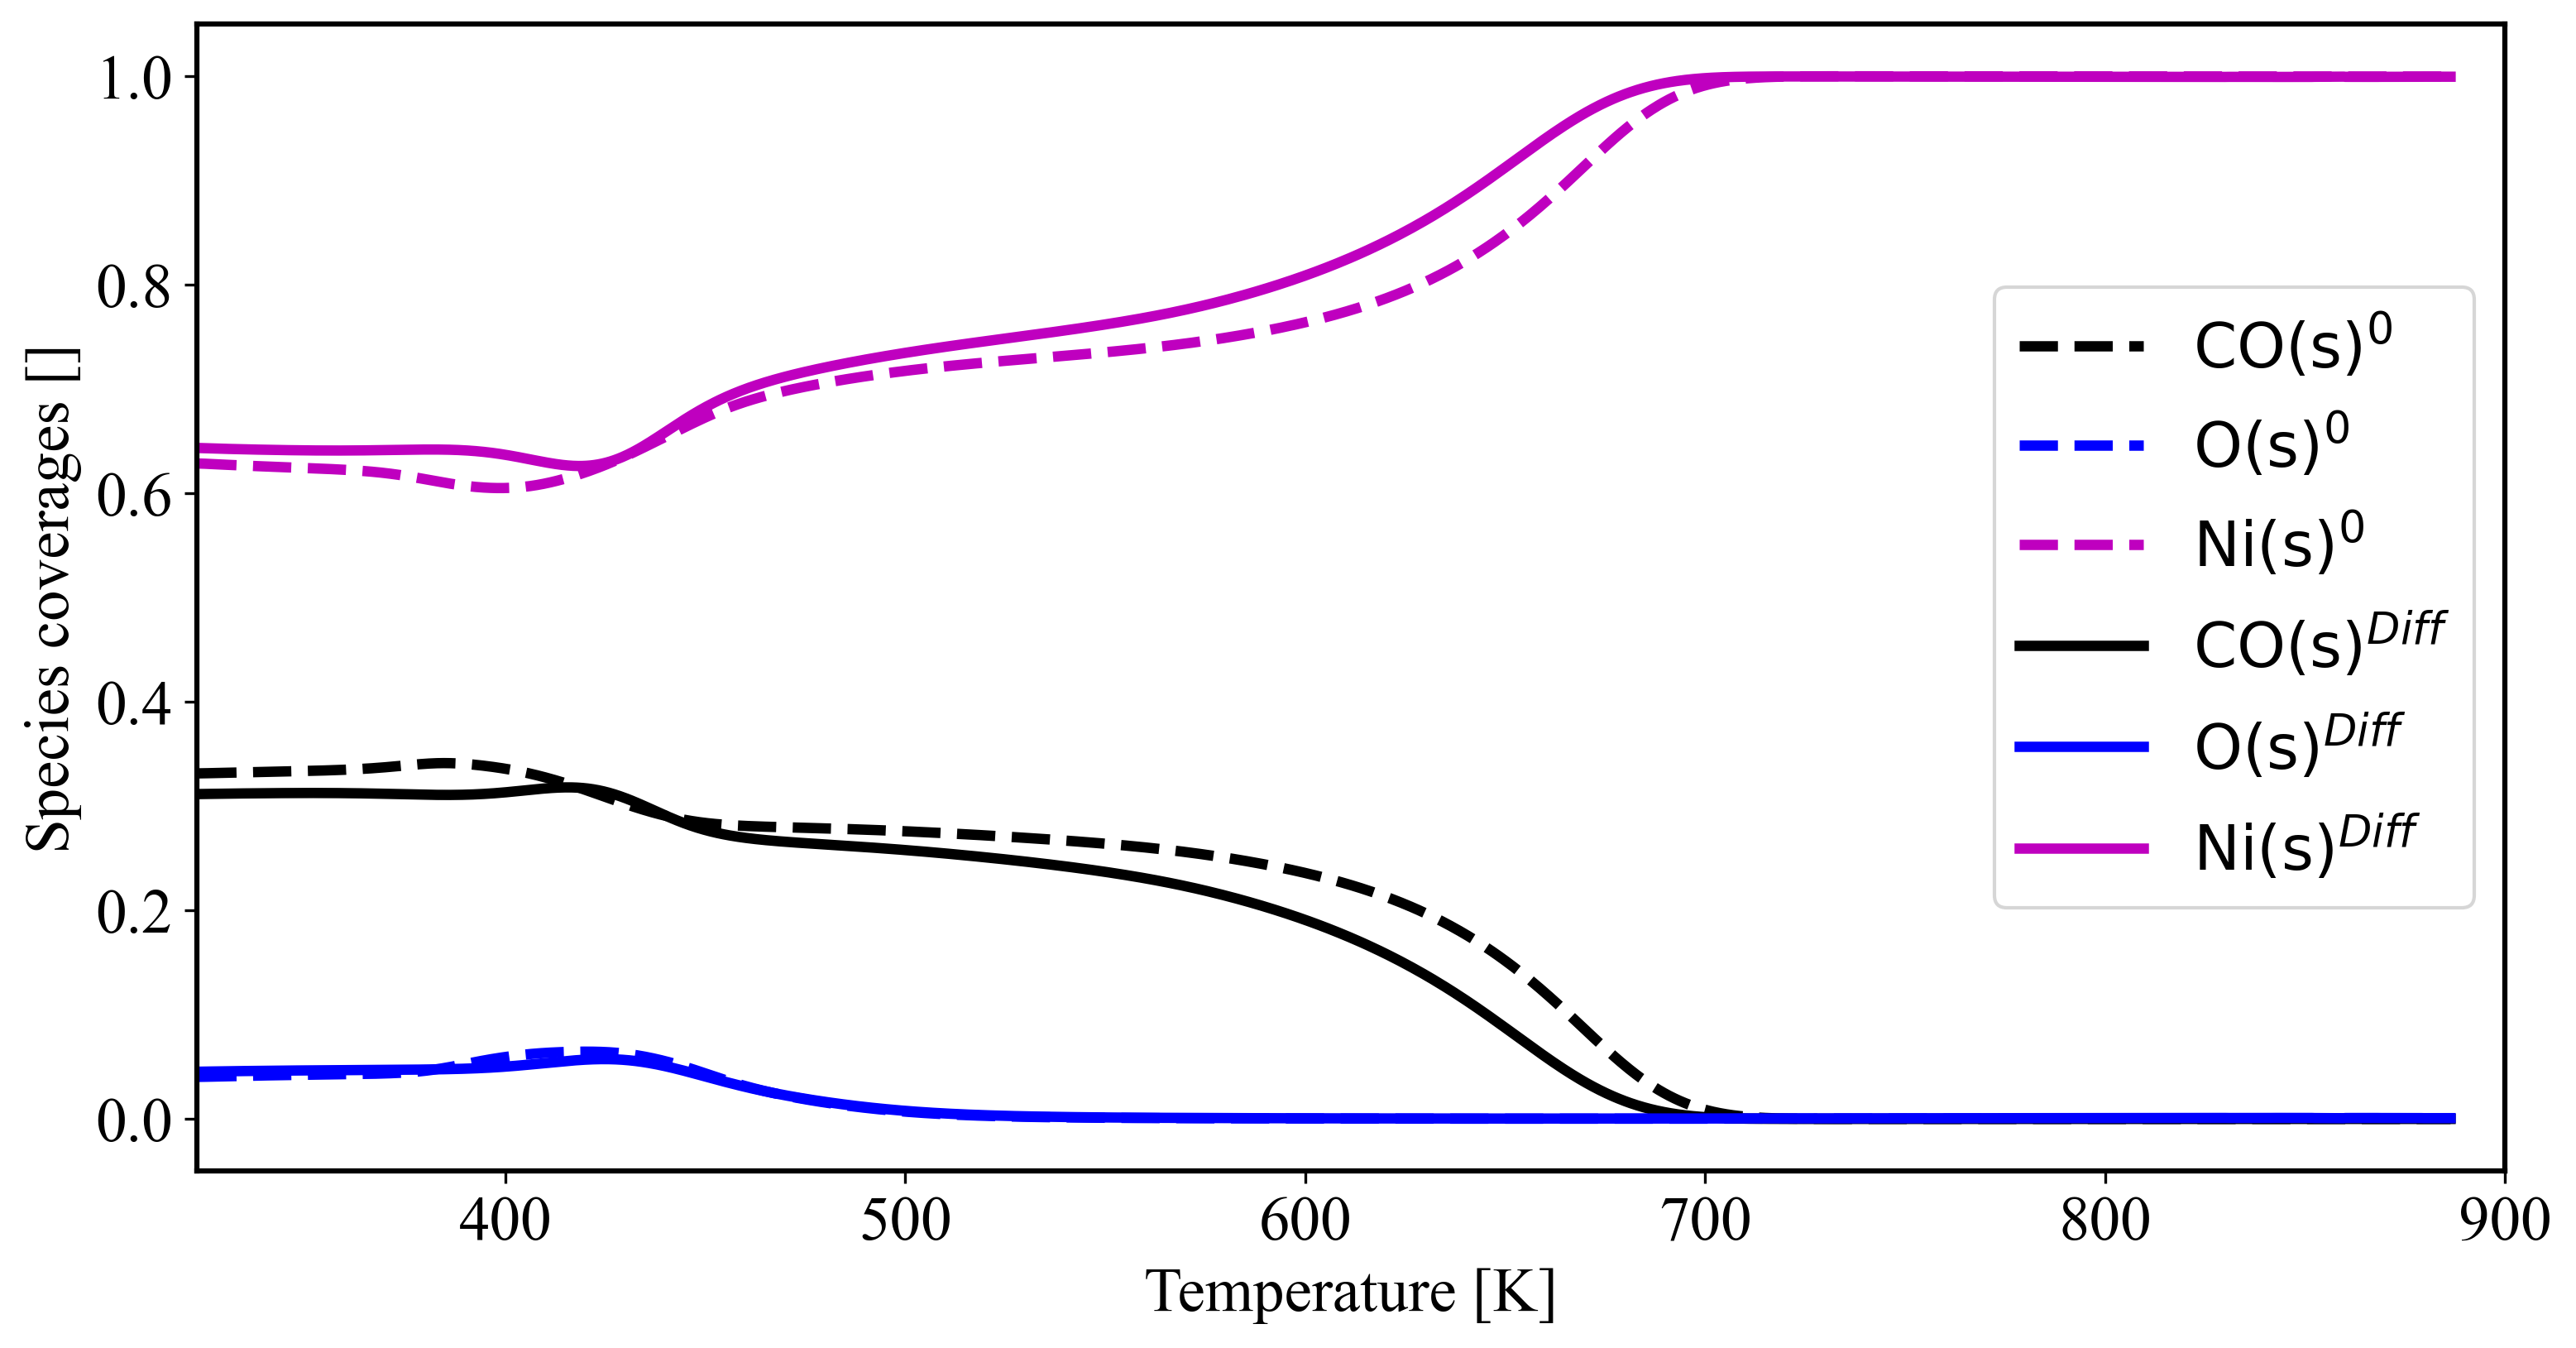

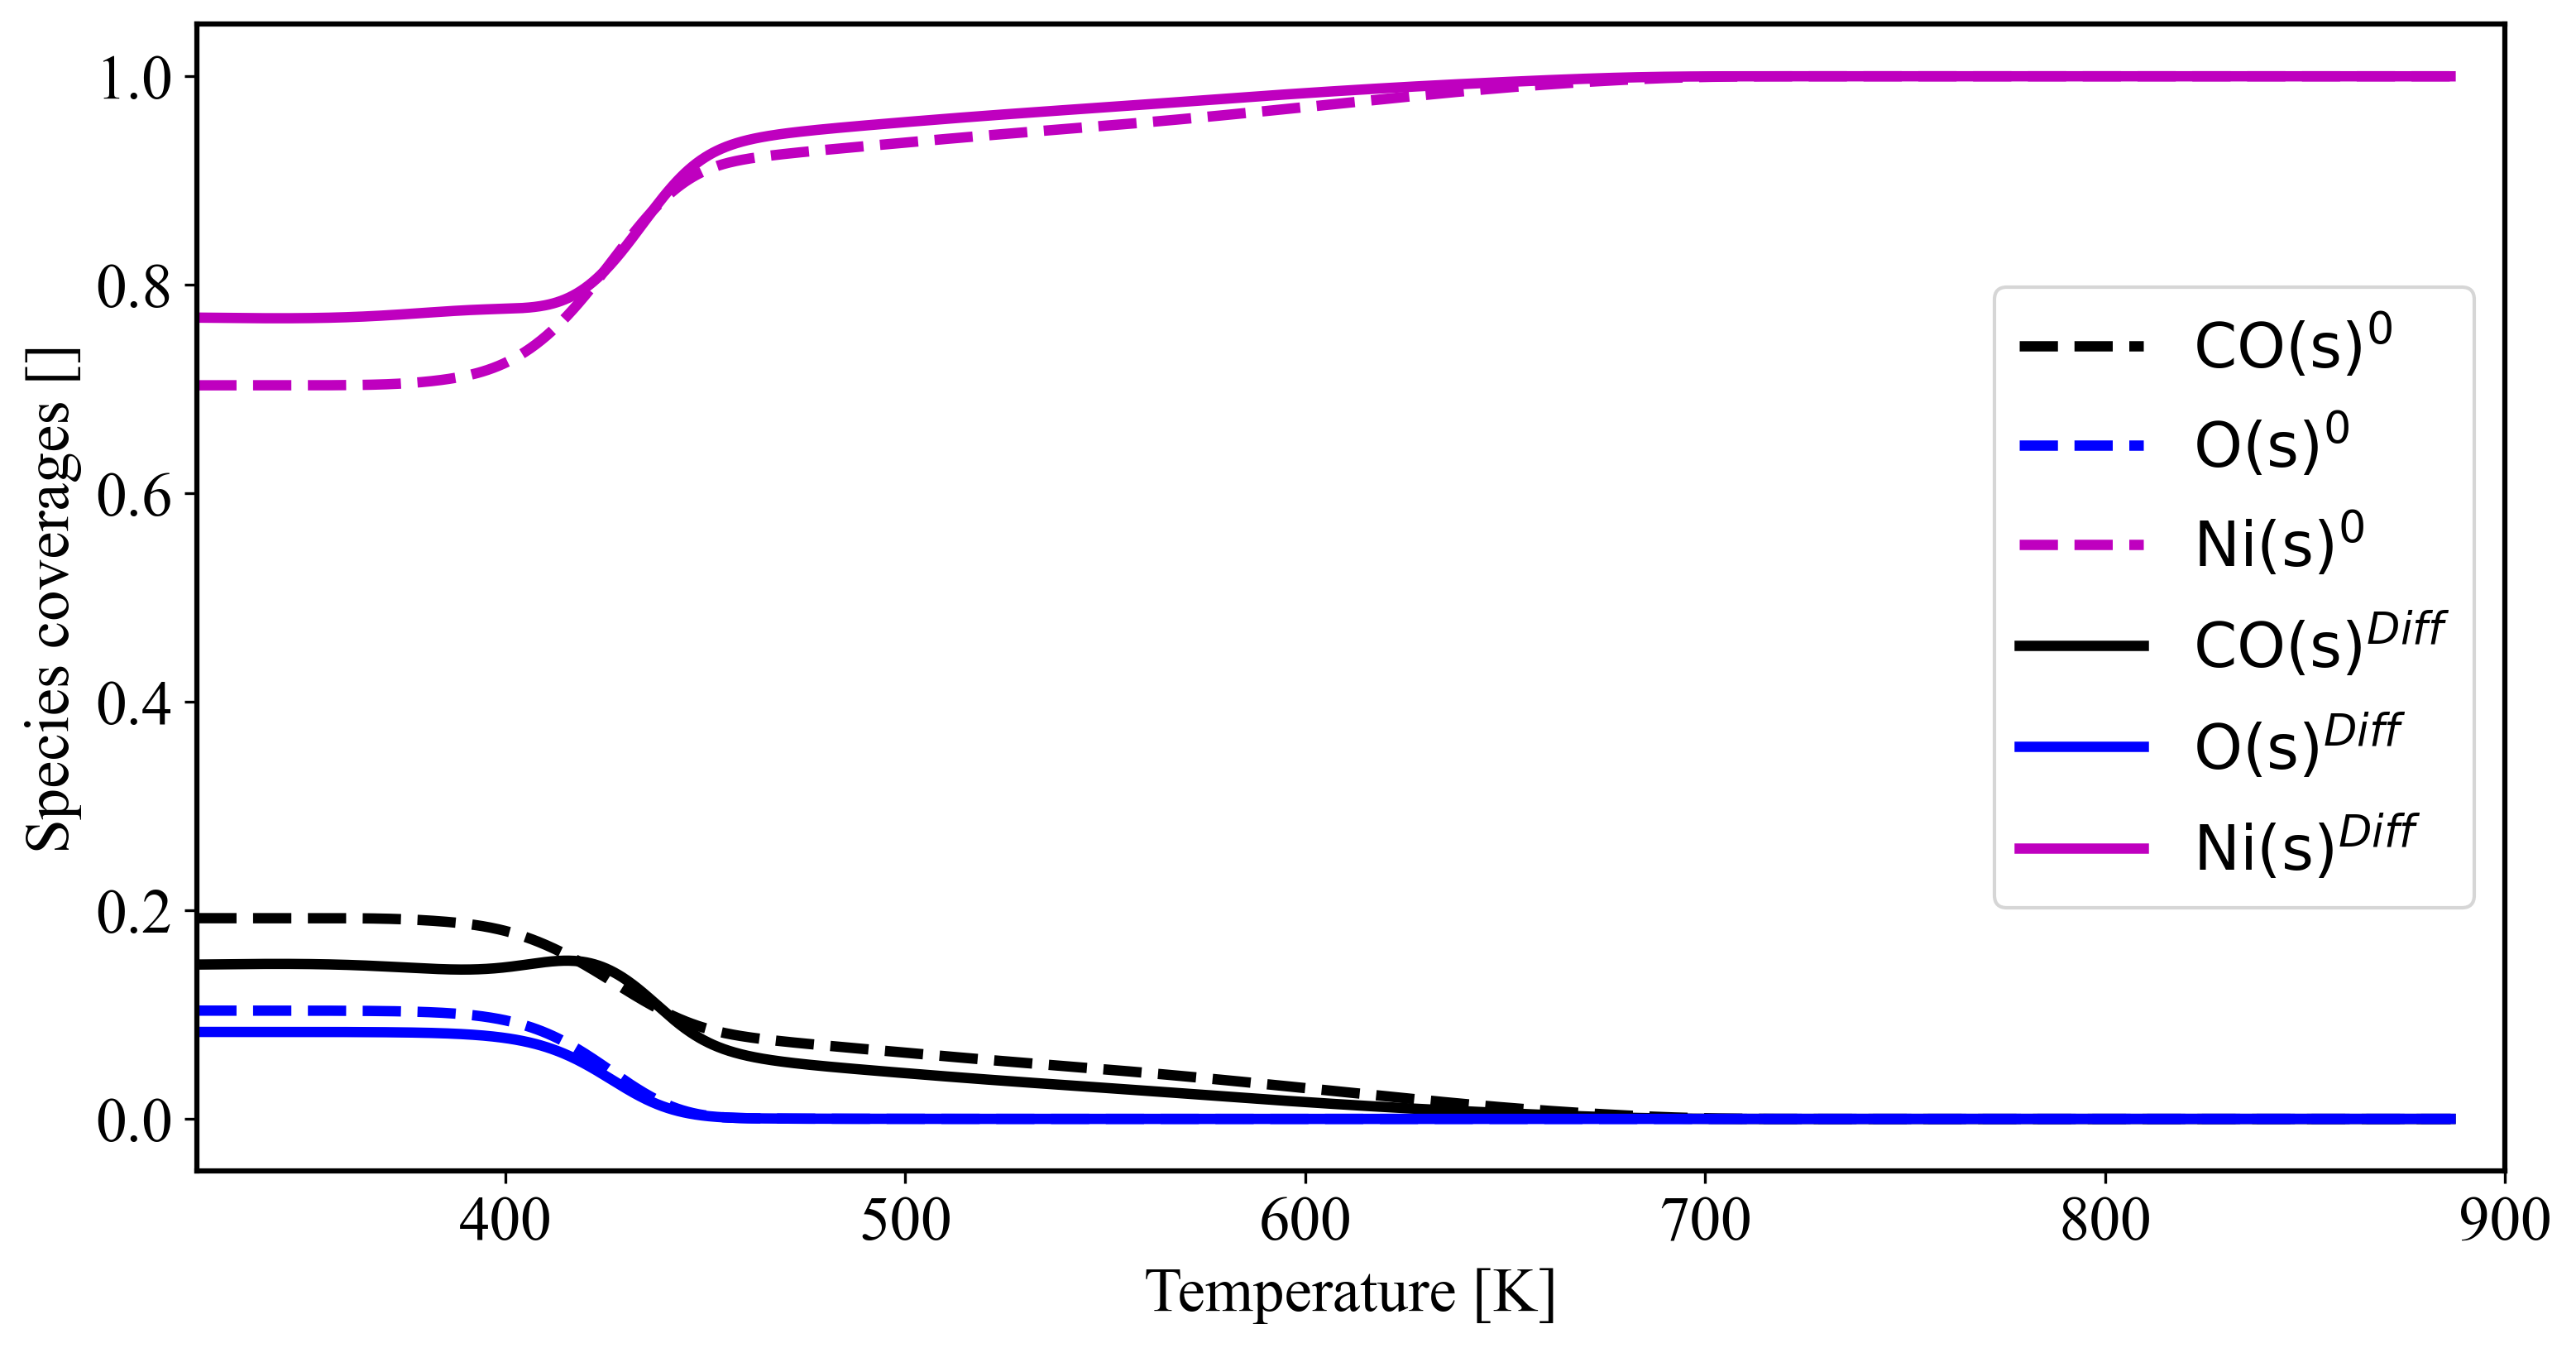

In [8]:
# Plot
plot_gasSpecies(sol0, sol1)

# Plot surface species
plot_surfSpecies(sol0, sol1, sol0.surf_fracs100, sol1.surf_fracs100, 'surf_coverages100')
plot_surfSpecies(sol0, sol1, sol0.surf_fracs211, sol1.surf_fracs211, 'surf_coverages211')
plot_surfSpecies(sol0, sol1, sol0.surf_fracs110, sol1.surf_fracs110, 'surf_coverages110')
plot_surfSpecies(sol0, sol1, sol0.surf_fracs111, sol1.surf_fracs111, 'surf_coverages111')

In [9]:
# # Comparison with the experimental data
# import pandas as pd
# filename = 'C:/Users/gkoge/Jupyter notebooks/multifacet/manuscript/TPD_experiments.csv'
# #print(filename)
# data = pd.read_csv(filename).values
# T_expt = data[:,0] + 273.15
# co2_expt = data[:,1]
# co_expt = data[:,2]

In [10]:
# # Plot
# plt.rcParams['figure.figsize']=(12,6)
# gs = gridspec.GridSpec(1, 1)
# plt.rcParams.update({'font.size': 24})
# gs.update(wspace = 0.4)
# ax0 = plt.subplot(gs[0])
# idx = 5410
# ax0.plot(T_expt, 1e4*co_expt, label='CO$^{expt}$',color='k', linestyle='dashed', linewidth=3)
# ax0.plot(sol0.Ti[idx:], 1e6*sol0.gas_mole_fracs[sol0.i_co,idx:], label='CO$^{0}$',color='k', linestyle='dashdot', linewidth=3)
# ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co,idx:], label='CO$^{diff}$',color='k', linewidth=3)
# ax0.plot(T_expt, 1e4*co2_expt, label='CO$_2^{expt}$',color='b', linestyle='dashed', linewidth=3)
# ax0.plot(sol0.Ti[idx:], 1e6*sol0.gas_mole_fracs[sol0.i_co2,idx:], label='CO$_2^{0}$',color='b', linestyle='dashdot', linewidth=3)
# ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co2,idx:], label='CO$_2^{diff}$',color='b', linewidth=3)
# ax0.set_xlabel('Temperature [K]')
# ax0.set_xlim([323, 900])
# #ax0.set_ylim([0, 1200])
# ax0.set_ylabel('Species concentration [ppm]')
# ax0.legend()
# plt.savefig('gasPhase_expt.png', dpi=300)
# plt.savefig('gasPhase_expt.svg', dpi=1000)
# #plt.savefig('gasPhase_expt.pdf', dpi=1000)
# plt.show()

In [11]:
# # Plot
# plt.rcParams['figure.figsize']=(12,6)
# gs = gridspec.GridSpec(1, 1)
# plt.rcParams.update({'font.size': 24})
# gs.update(wspace = 0.4)
# ax0 = plt.subplot(gs[0])
# idx = 5410
# ax0.plot(T_expt, 1e4*co_expt, label='CO$^{expt}$',color='k', linestyle='none', marker='+', markevery=15)
# #ax0.plot(sol0.Ti[idx:], 1e6*sol0.gas_mole_fracs[sol0.i_co,idx:], label='CO$^{0}$',color='k', linestyle='dashdot', linewidth=3)
# ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co,idx:], label='CO',color='k', linewidth=3)
# ax0.plot(T_expt, 1e4*co2_expt, label='CO$_2^{expt}$',color='b', linestyle='none', marker='+', markevery=15)
# #ax0.plot(sol0.Ti[idx:], 1e6*sol0.gas_mole_fracs[sol0.i_co2,idx:], label='CO$_2^{0}$',color='b', linestyle='dashdot', linewidth=3)
# ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co2,idx:], label='CO$_2$',color='b', linewidth=3)
# ax0.set_xlabel('Temperature [K]')
# ax0.set_xlim([323, 900])
# #ax0.set_ylim([0, 1200])
# ax0.set_ylabel('Species concentration [ppm]')
# ax0.legend()
# plt.savefig('gasPhase_expt.png', dpi=300)
# plt.savefig('gasPhase_expt.svg', dpi=1000)
# #plt.savefig('gasPhase_expt.pdf', dpi=1000)
# plt.show()

In [12]:
# # Function to perform the sensitivity analysis with respect to the rates
# def sens_rate(n, filename, facetName, nReactions):
#     heights_CO2,heights_CO=[],[]
#     temps_CO2,temps_CO=[],[]
    
#     dk=1.0e-2
#     #cycle through each reaction",surf.n_reactions
#     for m in range(nReactions):
        
#         # Run the simulation without the edge
#         sol_m = reactorCalc(n, facetName, "rate", 1+dk, m)
        
#         heights_CO2.append(sol_m.max_height_CO2)
#         temps_CO2.append(sol_m.max_Temp_CO2)

#         heights_CO.append(sol_m.max_height_CO)
#         temps_CO.append(sol_m.max_Temp_CO)
        
#     # Save the data
#     dataArray= np.zeros((4, nReactions))
#     dataArray[0][:] = heights_CO2
#     dataArray[1][:] = temps_CO2
#     dataArray[2][:] = heights_CO
#     dataArray[3][:] = temps_CO

#     # Take transpose
#     dataArray = np.transpose(dataArray)    
    
#     # Write to CSV
#     # field 
#     fields = ['Heights_CO2', 'Temps_CO2', 'Heights_CO', 'Temp_CO2'] 
#     write2CSV(filename, facetName, dataArray, fields) 
#     print(heights_CO2, heights_CO, temps_CO2, temps_CO)
                
#     return heights_CO2, heights_CO, temps_CO2, temps_CO            

In [13]:
# # Function to perform the sensitivity analysis with respect to the rates
# def sens_thermo(n, filename, facetName, nSpecies):
    
#     fields = ['Heights_CO2', 'Temps_CO2', 'Heights_CO', 'Temp_CO2']
#     #with open(filename, 'a', newline='') as csvfile:
#     #    # creating a csv writer object 
#     #    csvwriter = csv.writer(csvfile)        
#     #    # writing the fields 
#     #    csvwriter.writerow(fields)
        
#     heights_CO2,heights_CO=[],[]
#     temps_CO2,temps_CO=[],[]
    
#     dH=1.0e-2
#     dk = dH*1000 / 8.314  # for the thermo loop, 'dk' is in fact (delta H / R)
    
#     #cycle through each reaction",surf.n_reactions
#     for m in range(nSpecies):
        
#         # Run the simulation without the edge
#         sol_m = reactorCalc(n, facetName, "thermoChemistry", 1+dk, m)
        
#         heights_CO2.append(sol_m.max_height_CO2)
#         temps_CO2.append(sol_m.max_Temp_CO2)

#         heights_CO.append(sol_m.max_height_CO)
#         temps_CO.append(sol_m.max_Temp_CO)
        
#     # Save the data
#     dataArray= np.zeros((4, nSpecies))
#     dataArray[0][:] = heights_CO2
#     dataArray[1][:] = temps_CO2
#     dataArray[2][:] = heights_CO
#     dataArray[3][:] = temps_CO

#     # Take transpose
#     dataArray = np.transpose(dataArray)    
    
#     # Write to CSV
#     write2CSV(filename, facetName, dataArray, fields)
        
#     return heights_CO2, heights_CO, temps_CO2, temps_CO            

In [14]:
# # Sensitivity analysis based on chemical rates
# filename = "sensitivity_rate.csv"
# #[heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_rate(1, filename, "surf111", 5)
# #[heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_rate(1, filename,"surf100", 5)
# [heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_rate(1, filename,"surf211", 5)
# [heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_rate(1, filename,"surf110", 5)
# [heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_rate(1, filename,"edge12", 4)
# [heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_rate(1, filename,"edge23", 4)

          
# # Sensitivity analysis based on thermochemistry
# filename = "sensitivity_thermo.csv"
# #[heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_thermo(1, filename, "surf111", 6)
# #print(temps_CO2)

# #[heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_thermo(1, filename,"surf100", 6)
# #print(temps_CO2)

# #[heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_thermo(1, filename,"surf211", 3)
# #print(temps_CO2)

# #[heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_thermo(1, filename,"surf110", 6)
# #print(temps_CO2)

# # [heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_thermo(1, filename,"edge12", 1)
# # print(temps_CO2)

# # [heights_CO2, heights_CO, temps_CO2, temps_CO] = sens_thermo(1, filename,"edge23", 1)
# # print(temps_CO2)

In [15]:
# import csv
# filename = 'temp.csv'
# mode = 'a'
# # Save the data
# dataArray= np.zeros((4, 5))
# dataArray[0][:] = heights_CO2
# dataArray[1][:] = temps_CO2
# dataArray[2][:] = heights_CO
# dataArray[3][:] = temps_CO
# dataArray = np.transpose(dataArray)
# with open(filename, mode, newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(dataArray)
    